# Import Library

In [1]:
import numpy as np 
import math
import pandas as pd 
import pandas_datareader as pdr 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import dateutil.relativedelta
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks,optimizers
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import datetime
from datetime import  timedelta
from keras.models import load_model 
import math
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error            
seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')


Import Library yang digunakan

# Data Loading

In [2]:
data = pd.read_csv('machine_temperature_system_failure.csv')
data.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Load dataset sensor suhu

In [3]:
data.timestamp=pd.to_datetime(data.timestamp)
data.set_index('timestamp',inplace=True)

Merubah timestamp menjadi datetime dan menjadikanya index

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22695 entries, 2013-12-02 21:15:00 to 2014-02-19 15:25:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   22695 non-null  float64
dtypes: float64(1)
memory usage: 354.6 KB


Info dataset memiliki 22695 baris

In [5]:
data.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


Dari describe di atas bisa melihat mean, min, Q1, Q2 (Median), Q3 dan Max

# Exploratory Data Analysis

 Count row of data:  22695


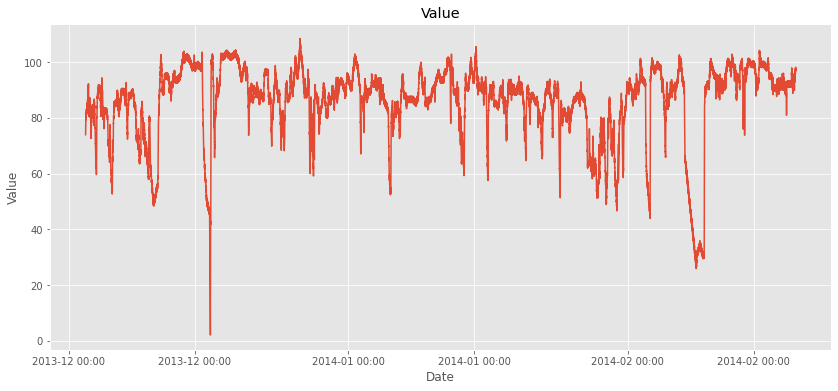

In [6]:
# use feature 'Date' & 'Close'
dataset = pd.DataFrame(data['value'])
print(' Count row of data: ',len(dataset))

fig = plt.figure(figsize=(14, 6))
plt.plot(dataset)
plt.xlabel('Date')
plt.ylabel('Value')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m %H:%M"))
plt.title('Value')
plt.show()

Plot value dari awal data hingga terakhir

In [7]:
dataset

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836
...,...
2014-02-19 15:05:00,98.185415
2014-02-19 15:10:00,97.804168
2014-02-19 15:15:00,97.135468


# Preprocessing

In [8]:
#Min-Max Normalization
dataset_norm = dataset.copy()
dataset[['value']]
scaler = MinMaxScaler()
dataset_norm['value'] = scaler.fit_transform(dataset[['value']])
dataset_norm

,value
timestamp,
2013-12-02 21:15:00,0.675424
2013-12-02 21:20:00,0.684525
2013-12-02 21:25:00,0.695691
2013-12-02 21:30:00,0.714638
2013-12-02 21:35:00,0.725812
...,...
2014-02-19 15:05:00,0.902983
2014-02-19 15:10:00,0.899401
2014-02-19 15:15:00,0.893117


Melakukan scalling menggunakan Min-Max karena data berdistribusi skew dan berfungsi untuk menghilangkan dan mengurangi redudansi data dan tujuan yang kedua adalah memastikan dependensi data

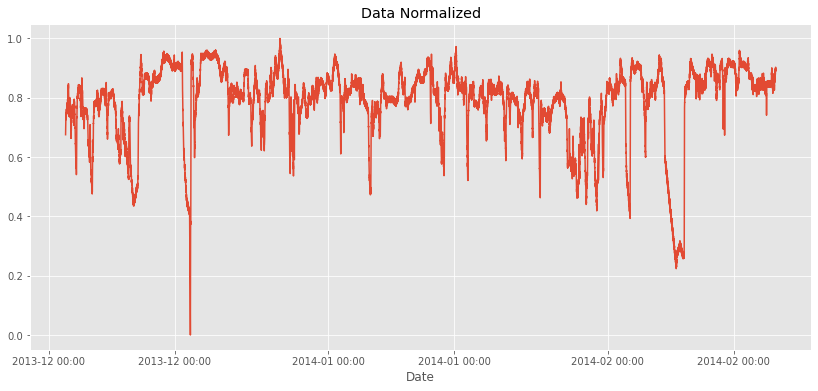

In [9]:
fig = plt.figure(figsize=(14, 6))
plt.plot(dataset_norm)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m %H:%M"))
plt.title('Data Normalized')
plt.show()

Plot data setelah dilakukan scaling

## Split Data

In [10]:
# Partition data into data train, val & test
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.7)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.2)

# Store data into each partition
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

Split data menjadi 3 train 70%, validation 10% dan test 20%

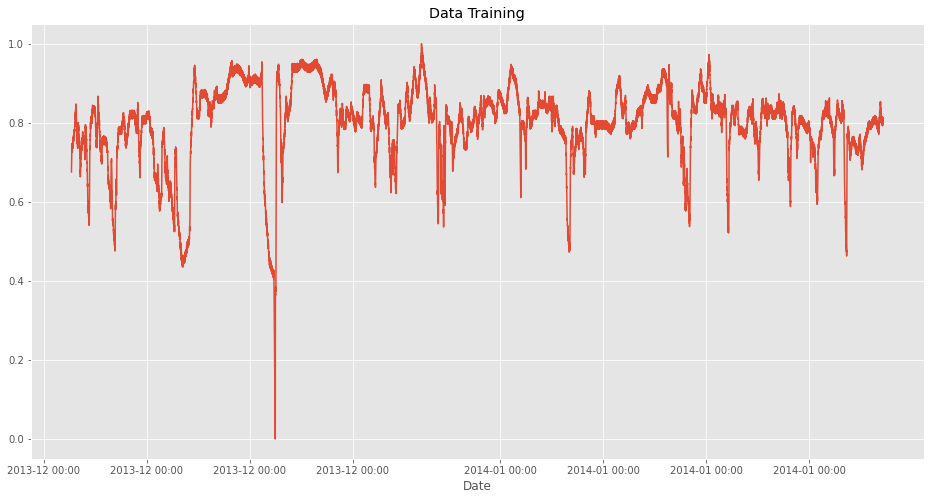

In [11]:
# graph data training
fig = plt.figure(figsize=(16, 8))
plt.plot(training_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m %H:%M"))
plt.title('Data Training')
plt.show()

Plot data train

,value
timestamp,
2014-01-27 00:05:00,0.811811
2014-01-27 00:10:00,0.794958
2014-01-27 00:15:00,0.807781
2014-01-27 00:20:00,0.811436
2014-01-27 00:25:00,0.800298
...,...
2014-02-03 20:45:00,0.893680
2014-02-03 20:50:00,0.894057
2014-02-03 20:55:00,0.895259


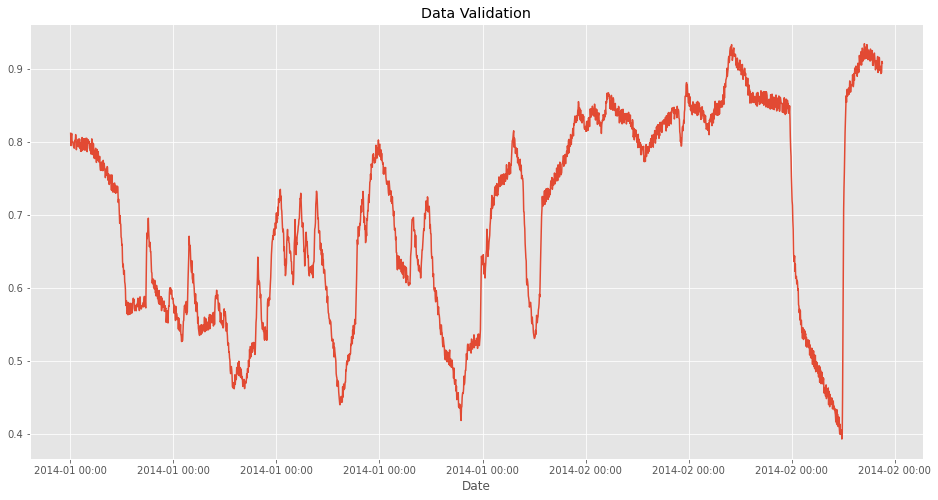

In [12]:
# graph data validation
fig = plt.figure(figsize=(16, 8))
plt.plot(val_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m %H:%M"))
plt.title('Data Validation')
val_set

Plot data validation

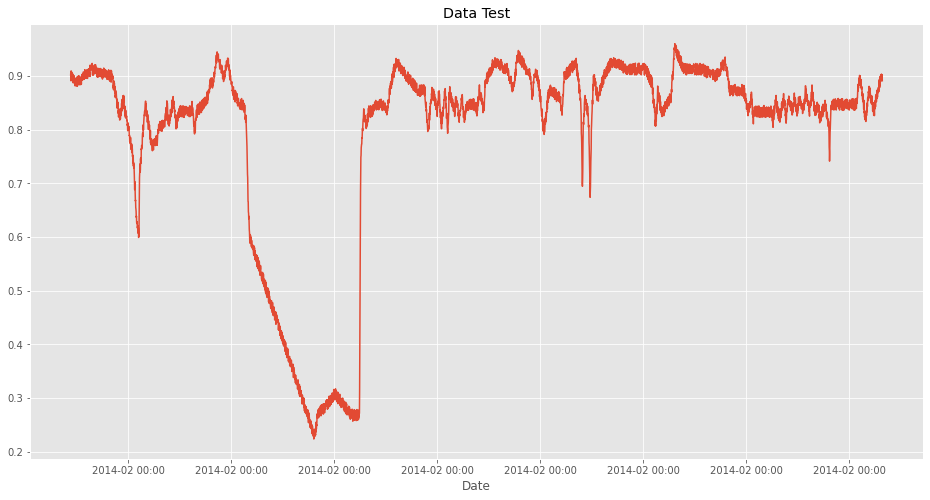

,value
timestamp,
2014-02-03 21:10:00,0.901745
2014-02-03 21:15:00,0.908201
2014-02-03 21:20:00,0.890743
2014-02-03 21:25:00,0.909150
2014-02-03 21:30:00,0.896302
...,...
2014-02-19 15:05:00,0.902983
2014-02-19 15:10:00,0.899401
2014-02-19 15:15:00,0.893117


In [13]:
# graph data test
fig = plt.figure(figsize=(16, 8))
plt.plot(test_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m %H:%M"))
plt.title('Data Test')
plt.show()
test_set

Plot data testing

## Sliding Windows

In [14]:
# Initiaton value of lag
lag = 2
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i,0])
        y.append(data[i,0]) 
    return np.array(x),np.array(y)

# Formating data into array for create sliding windows
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
# Create sliding windows into test data
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

# Modeling

In [15]:
tf.keras.backend.clear_session()
hidden_unit = 64

def create_hybrid(units):
        model = tf.keras.models.Sequential([
            tf.keras.layers.GRU(units=256, return_sequences=True, 
                        activation = "tanh",
                        input_shape=(x_train.shape[1],1)),
        tf.keras.layers.GRU(units=128,return_sequences=True),
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(1)])
        
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-4,
                                                             decay_steps=100000,
                                                             decay_rate=0.98,
                                                             staircase=False)

        model.compile(loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=['mae'])
        model.summary()

        return model
    
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-4,
                                                             decay_steps=100000,
                                                             decay_rate=0.98,
                                                             staircase=False)


model_hybrid = create_hybrid(64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 2, 256)            198912    
                                                                 
 gru_1 (GRU)                 (None, 2, 128)            148224    
                                                                 
 bidirectional (Bidirectiona  (None, 2, 256)           263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 2, 128)           164352    
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                1

Untuk modeling saya menggunakan Deep Learning dan melakukan hybrid model GRU dan Bi-LSTM, dimana GRU menggunakan 2 layer dan activation tanh, sedangkan Bi-LSTM menggunakan 2 layer. Untuk model compile nya menggunakan Optimizer : adam dan metrics : mae

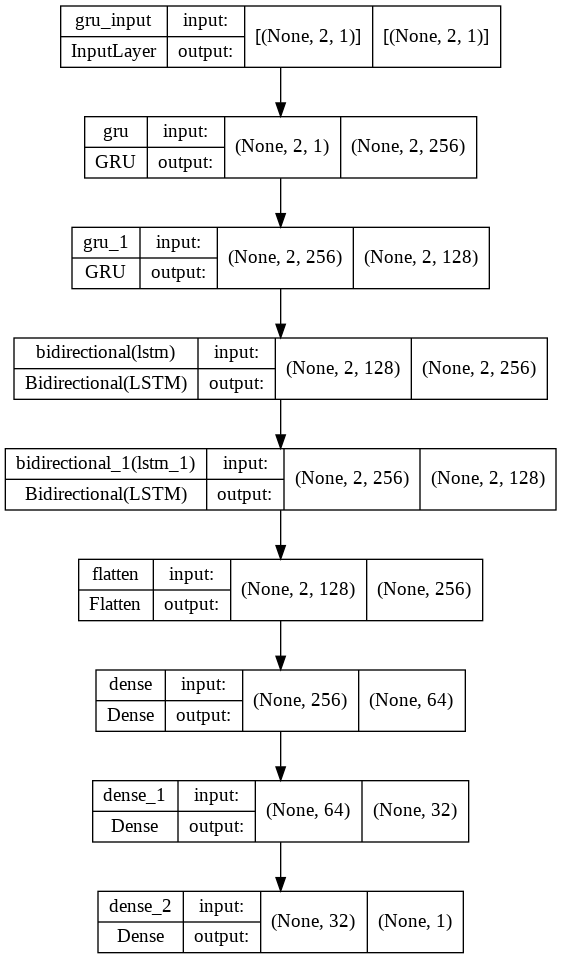

In [16]:
tf.keras.utils.plot_model(model_hybrid, show_shapes=True)

Diatas adalah plot dari mmodel hybrid GRU dan Bi-LSTM yang dibuat

In [17]:
def fit_model(model):
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val),
                    batch_size=64)
    return history

pred = fit_model(model_hybrid)

Epoch 1/100
249/249 [==============================] - 22s 19ms/step - loss: 0.0789 - mae: 0.1444 - val_loss: 0.0044 - val_mae: 0.0521
Epoch 2/100
249/249 [==============================] - 3s 12ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 0.0024 - val_mae: 0.0379
Epoch 3/100
249/249 [==============================] - 3s 12ms/step - loss: 4.9074e-04 - mae: 0.0149 - val_loss: 7.2218e-04 - val_mae: 0.0208
Epoch 4/100
249/249 [==============================] - 3s 11ms/step - loss: 1.8534e-04 - mae: 0.0096 - val_loss: 2.2337e-04 - val_mae: 0.0115
Epoch 5/100
249/249 [==============================] - 3s 12ms/step - loss: 1.3334e-04 - mae: 0.0084 - val_loss: 1.8005e-04 - val_mae: 0.0099
Epoch 6/100
249/249 [==============================] - 3s 11ms/step - loss: 1.3023e-04 - mae: 0.0084 - val_loss: 1.7406e-04 - val_mae: 0.0097
Epoch 7/100
249/249 [==============================] - 3s 13ms/step - loss: 1.3011e-04 - mae: 0.0084 - val_loss: 1.7287e-04 - val_mae: 0.0096
Epoch 8/100
249/249 [

Fit model menggunakan 100 epochs

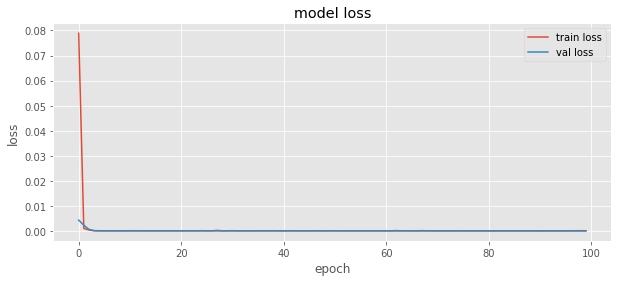

In [18]:
# Graph model loss (train loss & val loss)
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['loss'], label='train loss')
plt.plot(pred.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

Nilai loss dan val_loss mendapatkan hasil yang bagus dibawah 1 dengan nilai 0.000108 untuk loss dan 0.000175 nilai val_los dan memiliki gap yang sangat kecil

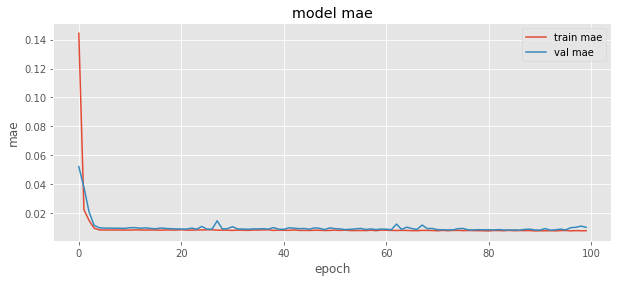

In [19]:
# Graph model loss (train loss & val loss)
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['mae'], label='train mae')
plt.plot(pred.history['val_mae'], label='val mae')
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

Nilia MAE dan val_mae juga memiliki nilai yang sangat bagus mendekati 0 dan memiliki gap yang sangat dekat. Maka bisa dikatakan model hybrid GRU dan Bi-LSTM ini goodfit

In [20]:
# Tabel value of training loss & validation loss
learningrate_parameter = lr_schedule
train_loss=pred.history['loss'][-1]
validation_loss=pred.history['val_loss'][-1]
learningrate_parameter=pd.DataFrame(data=[[learningrate_parameter, train_loss, validation_loss]],
                                    columns=['Learning Rate', 'Training Loss', 'Validation Loss'])
learningrate_parameter.set_index('Learning Rate')

,Training Loss,Validation Loss
Learning Rate,,
<keras.optimizer_v2.learning_rate_schedule.ExponentialDecay object at 0x7f9eb4b6d150>,0.000108,0.000175


In [21]:
# Implementation model into data test
y_pred_test = model_hybrid.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)

In [22]:
# Comparision data test with data prediction
datacompare = pd.DataFrame()
datatest=np.array(dataset['value'][totaldatatrain+totaldataval+lag:])
datapred= y_pred_invert_norm

datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred
datacompare

,Data Test,Prediction Results
0,96.882824,99.243866
1,98.841761,98.399689
2,97.474381,98.839050
3,97.492345,98.795311
4,98.622080,98.263519
...,...,...
4533,98.185415,98.457947
4534,97.804168,98.634865
4535,97.135468,98.733253
4536,98.056852,98.180061


Hasil dari prediksi model

In [23]:
### Calculate RMSE performance metrics

#math.sqrt(mean_squared_error(y_train,train_predict))
y = mean_squared_error(datatest,datapred ,squared=False)

x = mean_absolute_percentage_error(datatest,datapred)
x = x*100
print('Result Root Mean Square Error Prediction Model :',y)
print('Result Mean Absolute Percentage Error Prediction Model : ', float(np.round(x, 2)), '%')

Result Root Mean Square Error Prediction Model : 1.2662612008284997
Result Mean Absolute Percentage Error Prediction Model :  1.28 %


Evaluasi model menggunakan RMSE dan MAPE yang mendapatkan nilai sangat bagus karena mendekati 0, dimana nilai RMSE dan MAPE semakin mendekati 0 semakin bagus.

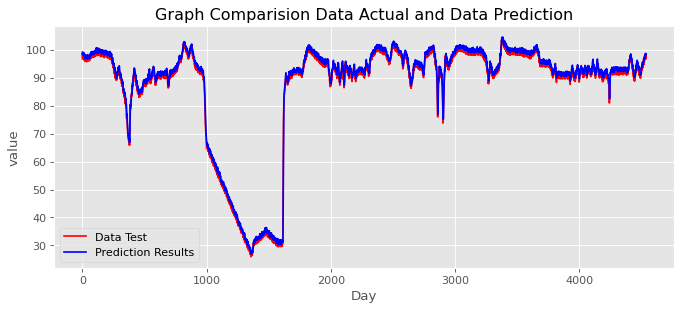

In [24]:
# Create graph data test and prediction result
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparision Data Actual and Data Prediction')
plt.plot(datacompare['Data Test'], color='red',label='Data Test')
plt.plot(datacompare['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('value')
plt.legend()
plt.show()

Plot hasil prediksi model hybrid GRU dan Bi-LSTM, bisa dilihat hasil prediksi model hybrid sangat mendekati aslinya, maka bisa dikatakan model hybrid yang telah dibuat untuk prediksi anomaly detection.

# Save Model

In [25]:
model_hybrid.save('Model.h5')

Save model hybrid GRU dan Bi-LSTM untuk proses deployment